In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
import re
import spacy
from spacy.lang.en import stop_words

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import feature_extraction
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import PredefinedSplit
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import shap

In [2]:
df = pd.read_csv("problem_merged_data.csv")

### Initial dataset exploration

In [3]:
df.shape

(1682, 24)

In [4]:
df.columns

Index(['group', 'item', 'channel', 'date', 'bid', 'budget', 'engagements',
       'page_views', 'clicks', 'active_days', 'media_spend', 'media_cpc',
       'cpe', 'headline', 'storySummary', 'IABCategory', 'targetGeo',
       'targetInterest', 'targetAge', 'targetOs', 'targetDevices',
       'targetGender', 'targetLanguages', 'CATEGORY_1'],
      dtype='object')

In [5]:
df.head()

,group,item,channel,date,bid,budget,engagements,page_views,clicks,active_days,...,storySummary,IABCategory,targetGeo,targetInterest,targetAge,targetOs,targetDevices,targetGender,targetLanguages,CATEGORY_1
0,37,997,YAHOO,2021-12-21,0.263696,660.923913,138,388,411,4,...,Peace of Mind with AAA Roadside Service. Join ...,Travel,"{""channelId"":""YAHOO"",""channelName"":""Yahoo"",""re...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,37,1372,YAHOO,2021-12-21,0.263043,235.217391,80,253,270,4,...,Peace of Mind with AAA Roadside Service. Join ...,Travel,"{""channelId"":""YAHOO"",""channelName"":""Yahoo"",""re...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,37,1372,YAHOO,2021-12-22,0.366809,1060.638298,251,856,905,5,...,Peace of Mind with AAA Roadside Service. Join ...,Travel,"{""channelId"":""YAHOO"",""channelName"":""Yahoo"",""re...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,37,997,YAHOO,2021-12-22,0.367447,2317.021277,219,687,723,5,...,Peace of Mind with AAA Roadside Service. Join ...,Travel,"{""channelId"":""YAHOO"",""channelName"":""Yahoo"",""re...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,37,997,YAHOO,2021-12-23,0.419130,2600.000000,201,682,722,6,...,Peace of Mind with AAA Roadside Service. Join ...,Travel,"{""channelId"":""YAHOO"",""channelName"":""Yahoo"",""re...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.describe()

,group,item,bid,budget,engagements,page_views,clicks,active_days,media_spend,media_cpc,cpe
count,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000
mean,49.879905,1052.561237,0.456941,137.875588,55.209869,131.042806,143.848395,56.795482,61.246843,0.478424,1.340462
std,7.580453,548.210311,0.207777,180.725259,49.443548,131.359557,140.945246,55.520905,52.971743,0.191657,0.851172
min,37.000000,12.000000,0.099762,5.842105,2.000000,24.000000,50.000000,1.000000,2.490000,0.030000,0.104409
25%,45.000000,673.750000,0.260000,68.399632,26.000000,58.000000,67.000000,12.000000,30.757500,0.342500,0.832027
50%,45.000000,1189.000000,0.500000,100.000000,42.000000,90.000000,98.000000,30.000000,46.880000,0.490000,1.111765
75%,53.000000,1511.000000,0.600000,147.577298,66.750000,149.000000,164.000000,105.750000,79.292500,0.607500,1.653750
max,83.000000,1836.000000,1.170000,2600.000000,558.000000,1552.000000,1634.000000,199.000000,707.810000,1.590000,7.547500


In [7]:
# check variable types
df.dtypes

group                int64
item                 int64
channel             object
date                object
bid                float64
budget             float64
engagements          int64
page_views           int64
clicks               int64
active_days          int64
media_spend        float64
media_cpc          float64
cpe                float64
headline            object
storySummary        object
IABCategory         object
targetGeo           object
targetInterest      object
targetAge           object
targetOs            object
targetDevices       object
targetGender        object
targetLanguages     object
CATEGORY_1          object
dtype: object

In [8]:
# check for standard missing values per columns
df.isnull().sum()

group                 0
item                  0
channel               0
date                  0
bid                   0
budget                0
engagements           0
page_views            0
clicks                0
active_days           0
media_spend           0
media_cpc             0
cpe                   0
headline              0
storySummary          0
IABCategory           0
targetGeo             0
targetInterest      979
targetAge          1024
targetOs           1024
targetDevices      1024
targetGender       1024
targetLanguages    1024
CATEGORY_1          640
dtype: int64

In [9]:
cat_features = ["channel", "targetAge", "targetOs", "targetDevices", "targetGender", "targetLanguages", "IABCategory", "CATEGORY_1"]

for feature in cat_features:
    print(f"Unique values of feature '{feature}'")
    print(f"Number of unique values: {df[feature].nunique()}")
    print(f"{df[feature].value_counts()}\n");

Unique values of feature 'channel'
Number of unique values: 3
channel
YAHOO         1085
REVCONTENT     596
MGID             1
Name: count, dtype: int64

Unique values of feature 'targetAge'
Number of unique values: 4
targetAge
65+;      393
55-64;    158
35-44;     72
45-54;     35
Name: count, dtype: int64

Unique values of feature 'targetOs'
Number of unique values: 2
targetOs
IOS;        490
ANDROID;    168
Name: count, dtype: int64

Unique values of feature 'targetDevices'
Number of unique values: 1
targetDevices
SMARTPHONES;    658
Name: count, dtype: int64

Unique values of feature 'targetGender'
Number of unique values: 2
targetGender
MALE;      535
FEMALE;    123
Name: count, dtype: int64

Unique values of feature 'targetLanguages'
Number of unique values: 1
targetLanguages
en;    658
Name: count, dtype: int64

Unique values of feature 'IABCategory'
Number of unique values: 4
IABCategory
Medical Health          940
Business and Finance    500
Travel                  217
News a

### Preprocessing

In [10]:
processed_df = df.copy()

All target columns where the value is NaN will not be considered missing. Instead, the interpretation is that the lack of target means all audience.
Thus, fill NaNs with 'all' in those columns. 

In [11]:
targeting_columns_with_nan = ["targetAge", "targetOs", "targetDevices", "targetGender", "targetLanguages"]

In [12]:
processed_df[targeting_columns_with_nan] = processed_df[targeting_columns_with_nan].fillna('all')

Some features have ";" at the end of each categorical value.

In [13]:
cat_columns_semicolon = ["targetAge", "targetOs", "targetDevices", "targetGender", "targetLanguages"]
processed_df[cat_columns_semicolon] = processed_df[cat_columns_semicolon].map(lambda x: x.rstrip(';'))

#### Json-like features

In [113]:
def extract_json(json_str, str_key):
    """
    Extracts unique values associated with a specified key from a JSON-formatted string.

    Parameters:
    - json_str (str): A string in JSON format containing key-value pairs separated by ';'.
    - str_key (str): The key of interest whose associated values will be extracted.

    Returns:
    - list: A list of unique values associated with the specified key.

    Notes:
    The function splits the input JSON string by ';' delimiter and retrieves the value associated with the specified key for each item.
    It then ensures uniqueness of the extracted values and returns them as a list.
    If the input string is empty or NaN, an empty list is returned.
    """
    if pd.isna(json_str):
        return []
        
    items = json_str.split(';')
    key_values = []
    values_set = set()
    
    for item in items:
        # handle the case of the end of json_str, after the last ';' separator
        if item == "": 
            return key_values
        
        key_value = json.loads(item)[str_key]
        
        if key_value not in values_set:
            key_values.append(key_value)
            values_set.add(key_value)  

    return key_values

##### TargetGeo

For TargetGeo, there are many levels of geographical coverage ('geoType' - as referenced is the feature), from country to postal code. 
Below these levels are extracted to understand if each ad item has multiple target levels at the same time.

In [15]:
# apply the function to create a new column with a list of geotype values per row
processed_df['all_geotypes'] = processed_df['targetGeo'].apply(lambda x: extract_json(x, 'geoType'))

# extract individual geotype values into separate columns
max_geotype_count = processed_df['all_geotypes'].apply(len).max()

for i in range(max_geotype_count):
    processed_df[f'geotype_{i+1}'] = processed_df['all_geotypes'].apply(lambda x: x[i] if len(x) > i else None)

processed_df.head()


,group,item,channel,date,bid,budget,engagements,page_views,clicks,active_days,...,targetInterest,targetAge,targetOs,targetDevices,targetGender,targetLanguages,CATEGORY_1,all_geotypes,geotype_1,geotype_2
0,37,997,YAHOO,2021-12-21,0.263696,660.923913,138,388,411,4,...,NaN,all,all,all,all,all,NaN,[DMA],DMA,None
1,37,1372,YAHOO,2021-12-21,0.263043,235.217391,80,253,270,4,...,NaN,all,all,all,all,all,NaN,[DMA],DMA,None
2,37,1372,YAHOO,2021-12-22,0.366809,1060.638298,251,856,905,5,...,NaN,all,all,all,all,all,NaN,[DMA],DMA,None
3,37,997,YAHOO,2021-12-22,0.367447,2317.021277,219,687,723,5,...,NaN,all,all,all,all,all,NaN,[DMA],DMA,None
4,37,997,YAHOO,2021-12-23,0.419130,2600.000000,201,682,722,6,...,NaN,all,all,all,all,all,NaN,[DMA],DMA,None


DMA stands for Designated Market Areas (region usually metropolitan areas combining suburbs, 210 in the United States).
If we were to extract each city, each postal code, etc. the dimension of the dataset would grow a lot and be very sparse, since only ~10% of entries has Geotype CITY, and only other ~10% POSTALCODE.

In [16]:
processed_df['geotype_1'].value_counts()

geotype_1
BUCKET        926
REGION        183
POSTALCODE    180
COUNTRY       175
CITY          149
DMA            69
Name: count, dtype: int64

Most advertisement items only have one Geotype. Some have two geotypes, being the combinations:
- CITY and DMA
- POSTALCODE and REGION
In these cases it makes sense to consider the first, since it represents a more specific target.

In [17]:
processed_df['geotype_2'].unique()

array([None, 'DMA', 'REGION'], dtype=object)

In [18]:
processed_df.query("geotype_2 == 'DMA'")['geotype_1'].unique()

array(['CITY'], dtype=object)

In [19]:
processed_df.query("geotype_2 == 'REGION'")['geotype_1'].unique()

array(['POSTALCODE'], dtype=object)

It makes more sense to use the Geographical info as a nominal category, specifying if the ad is targeted for a big number of people (country) or small and specific (postalcode).
The column of the first GeoType will be used in the model.

In [20]:
processed_df.rename(columns={'geotype_1': 'targetGeo_new'}, inplace=True)

##### TargetInterest

In [21]:
processed_df['all_interestids'] = processed_df['targetInterest'].apply(lambda x: extract_json(x, 'interestName'))

max_interestids_count = processed_df['all_interestids'].apply(len).max()

for i in range(max_interestids_count):
    processed_df[f'interest_{i+1}'] = processed_df['all_interestids'].apply(lambda x: x[i] if len(x) > i else None)

processed_df.head()

,group,item,channel,date,bid,budget,engagements,page_views,clicks,active_days,...,targetOs,targetDevices,targetGender,targetLanguages,CATEGORY_1,all_geotypes,targetGeo_new,geotype_2,all_interestids,interest_1
0,37,997,YAHOO,2021-12-21,0.263696,660.923913,138,388,411,4,...,all,all,all,all,NaN,[DMA],DMA,None,[],None
1,37,1372,YAHOO,2021-12-21,0.263043,235.217391,80,253,270,4,...,all,all,all,all,NaN,[DMA],DMA,None,[],None
2,37,1372,YAHOO,2021-12-22,0.366809,1060.638298,251,856,905,5,...,all,all,all,all,NaN,[DMA],DMA,None,[],None
3,37,997,YAHOO,2021-12-22,0.367447,2317.021277,219,687,723,5,...,all,all,all,all,NaN,[DMA],DMA,None,[],None
4,37,997,YAHOO,2021-12-23,0.419130,2600.000000,201,682,722,6,...,all,all,all,all,NaN,[DMA],DMA,None,[],None


There are multiple Target Interests specified, and they can be aggregated to reduce dimensionality when encoding.

In [22]:
processed_df['interest_1'].value_counts()

interest_1
Hypertension Propensity - Reach Tier 1 [3rd Party Data > Adstra (ALC) > Syndicated > Health & Wellness > Disease Propensity by Type/Rx Use]                        132
Hypertension Propensity - Reach Tier 3 [3rd Party Data > Adstra (ALC) > Syndicated > Health & Wellness > Disease Propensity by Type/Rx Use]                        115
Travel [Verizon Media > Interest]                                                                                                                                   94
Heart Disease [3rd Party Data > Liveramp Data Store - 3rd Party > Lifescript > Declared Health Interest]                                                            72
Business and Industry [Verizon Media > Interest]                                                                                                                    65
Insurance [Verizon Media > Interest > Business and Industry > Personal finance]                                                                           

In [23]:
health_interest_list = [
    "Hypertension Propensity - Reach Tier 1 [3rd Party Data > Adstra (ALC) > Syndicated > Health & Wellness > Disease Propensity by Type/Rx Use]",
    "Hypertension Propensity - Reach Tier 3 [3rd Party Data > Adstra (ALC) > Syndicated > Health & Wellness > Disease Propensity by Type/Rx Use]",
    "Hypertension Propensity - Reach Tier 3 [3rd Party Data > Adstra (ALC) > Syndicated > Health & Wellness > Disease Propensity by Type/Rx Use]",
    "Hypertension Propensity Caregivers - Reach Tier 2 [3rd Party Data > Adstra (ALC) > Syndicated > Caregivers > Caregivers by Condition Propensity by Type/Rx Use]",
    "Heart Disease [3rd Party Data > Liveramp Data Store - 3rd Party > Lifescript > Declared Health Interest]",                        
    "Fitness and wellness [Verizon Media > Interest]"
]

travel_interest_list = [
    "Travel [Verizon Media > Interest]",
    "Travel [Verizon Media > Household & Lifestages > TV Viewership, powered by Vizio > Genre Viewership > Shows]"
]

tech_interest_list = [
    "Technology [Verizon Media > Interest]",
    "Computers [Verizon Media > Interest > Technology]",
    "Computer processors [Verizon Media > Interest > Technology > Computers]", 
    "Computer servers [Verizon Media > Interest > Technology > Computers]",
    "Network storage [Verizon Media > Interest > Technology > Computers]",
    "Computer monitors [Verizon Media > Interest > Technology > Computers]"
]

business_interest_list = [
    "Business and Industry [Verizon Media > Interest]",
    "B2B [Verizon Media > Interest > Business and Industry]",
    "Small business [Verizon Media > Interest > Business and Industry]", 
    "Small Business Owners [Verizon Media > Household & Lifestages > Business, Careers, & Industry]", 
    "Health care [Verizon Media > Interest > Business and Industry]",
    "Insurance [Verizon Media > Interest > Business and Industry > Personal finance]"
]

def aggregate_interest(row):
    if row['interest_1'] in health_interest_list:
        return 'health'
    
    if row['interest_1'] in travel_interest_list:
        return 'travel'
    
    if row['interest_1'] in tech_interest_list:
        return 'tech'
    
    if row['interest_1'] in business_interest_list:
        return 'business'
    
    if pd.isna(row['interest_1']):
        return 'not specific - all interests'
    
    return 'other'

processed_df['agg_target_interest'] = processed_df.apply(aggregate_interest, axis=1)
processed_df.head()

,group,item,channel,date,bid,budget,engagements,page_views,clicks,active_days,...,targetDevices,targetGender,targetLanguages,CATEGORY_1,all_geotypes,targetGeo_new,geotype_2,all_interestids,interest_1,agg_target_interest
0,37,997,YAHOO,2021-12-21,0.263696,660.923913,138,388,411,4,...,all,all,all,NaN,[DMA],DMA,None,[],None,not specific - all interests
1,37,1372,YAHOO,2021-12-21,0.263043,235.217391,80,253,270,4,...,all,all,all,NaN,[DMA],DMA,None,[],None,not specific - all interests
2,37,1372,YAHOO,2021-12-22,0.366809,1060.638298,251,856,905,5,...,all,all,all,NaN,[DMA],DMA,None,[],None,not specific - all interests
3,37,997,YAHOO,2021-12-22,0.367447,2317.021277,219,687,723,5,...,all,all,all,NaN,[DMA],DMA,None,[],None,not specific - all interests
4,37,997,YAHOO,2021-12-23,0.419130,2600.000000,201,682,722,6,...,all,all,all,NaN,[DMA],DMA,None,[],None,not specific - all interests


In [24]:
processed_df['agg_target_interest'].value_counts()

agg_target_interest
not specific - all interests    979
health                          333
business                        150
travel                           96
tech                             94
other                            30
Name: count, dtype: int64

### EDA

#### Distributions of bid, budget and CPE

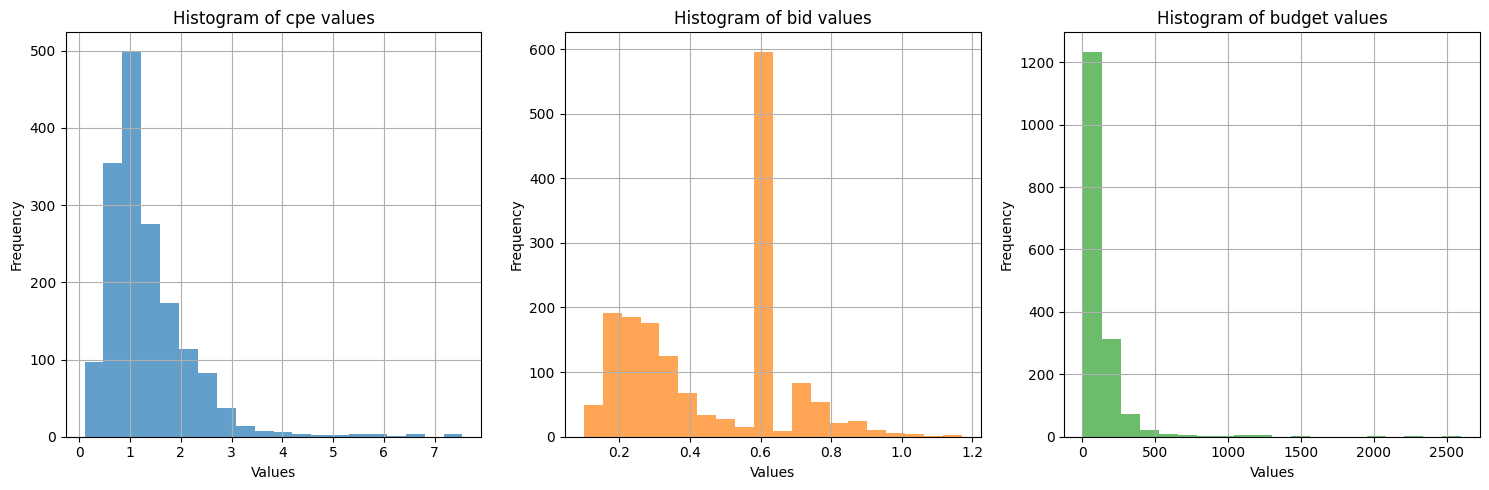

In [25]:
columns_to_plot = ['cpe', 'bid', 'budget']

fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(15, 5))

for i, col in enumerate(columns_to_plot):
    axes[i].hist(processed_df[col], bins=20, color='C{}'.format(i), alpha=0.7)
    axes[i].set_title('Histogram of {} values'.format(col))
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

#### Relationship between bid, budget vs CPE

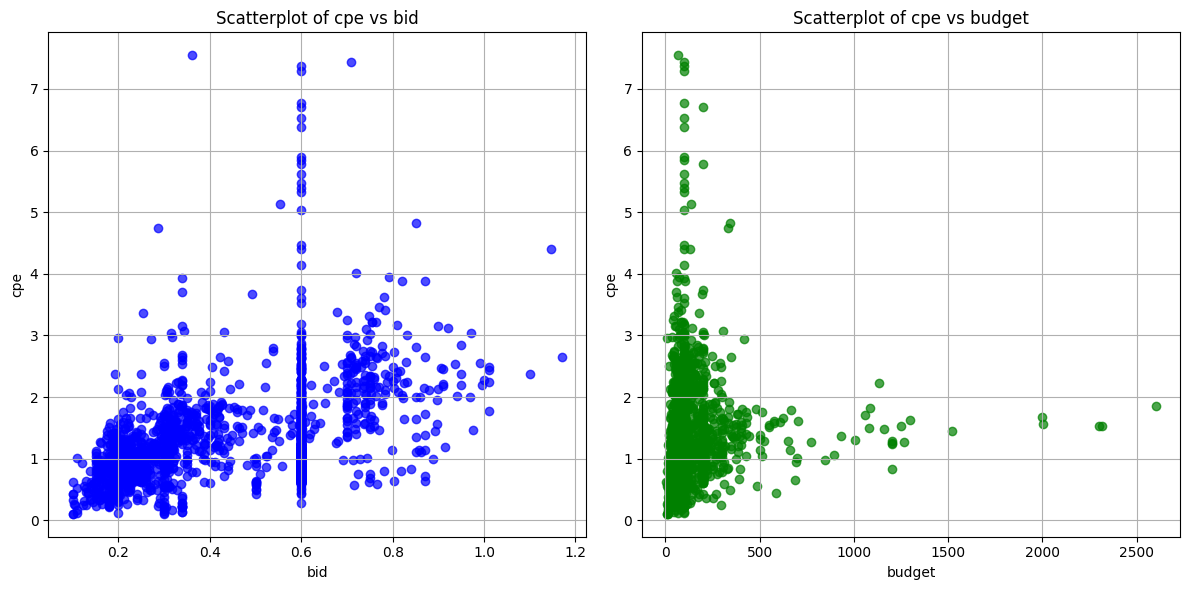

In [26]:
#scatter cpe bid
#scatter cpe budget
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].scatter(processed_df['bid'], processed_df['cpe'], color='blue', alpha=0.7)
axes[0].set_title('Scatterplot of cpe vs bid')
axes[0].set_xlabel('bid')
axes[0].set_ylabel('cpe')
axes[0].grid(True)

axes[1].scatter(processed_df['budget'], processed_df['cpe'], color='green', alpha=0.7)
axes[1].set_title('Scatterplot of cpe vs budget')
axes[1].set_xlabel('budget')
axes[1].set_ylabel('cpe')
axes[1].grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

- There are a lo of bid at 0.6, maybe a default value?
- Highest CPEs have a budget smaller than 500
- High budgets (> 500) tend to have maximum CPE of 2

#### Relationship bid vs budget vs CPE

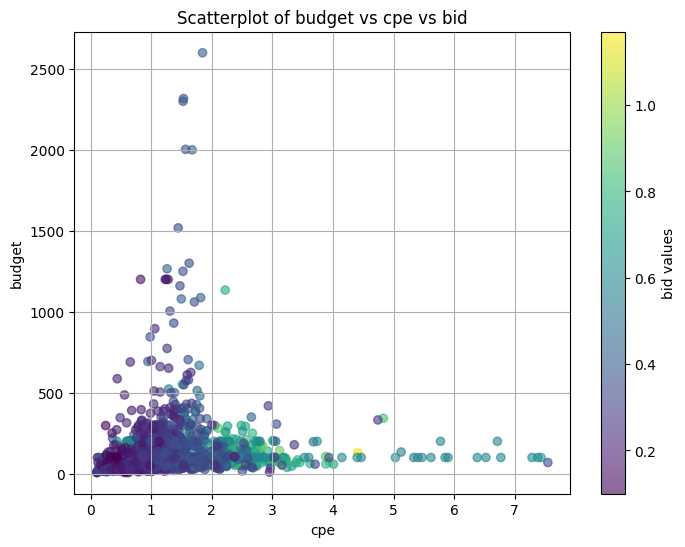

In [93]:
plt.figure(figsize=(8, 6))
plt.scatter(processed_df['cpe'], processed_df['budget'], c=processed_df['bid'], cmap='viridis', alpha=0.6)
plt.colorbar(label='bid values')
plt.title('Scatterplot of budget vs cpe vs bid')
plt.xlabel('cpe')
plt.ylabel('budget')
plt.grid(True)
plt.show()

Some interesting things from the plot above:
- A higher budget is not connected to higher bids.
- Higher budgets (>= 500) will almost always have a cpe of less than 2. While many lower budgets have cpes of more than 7.
- Low budgets (< 500) with high bids (>0.6) generate the greatest cpes

#### CPE per Targets

Hyphothesis:

CPE should be lower for well defined targets and higher for the items advertised to 'all' targets. This is confirmed below, with the 'all' categories having many more outliers.

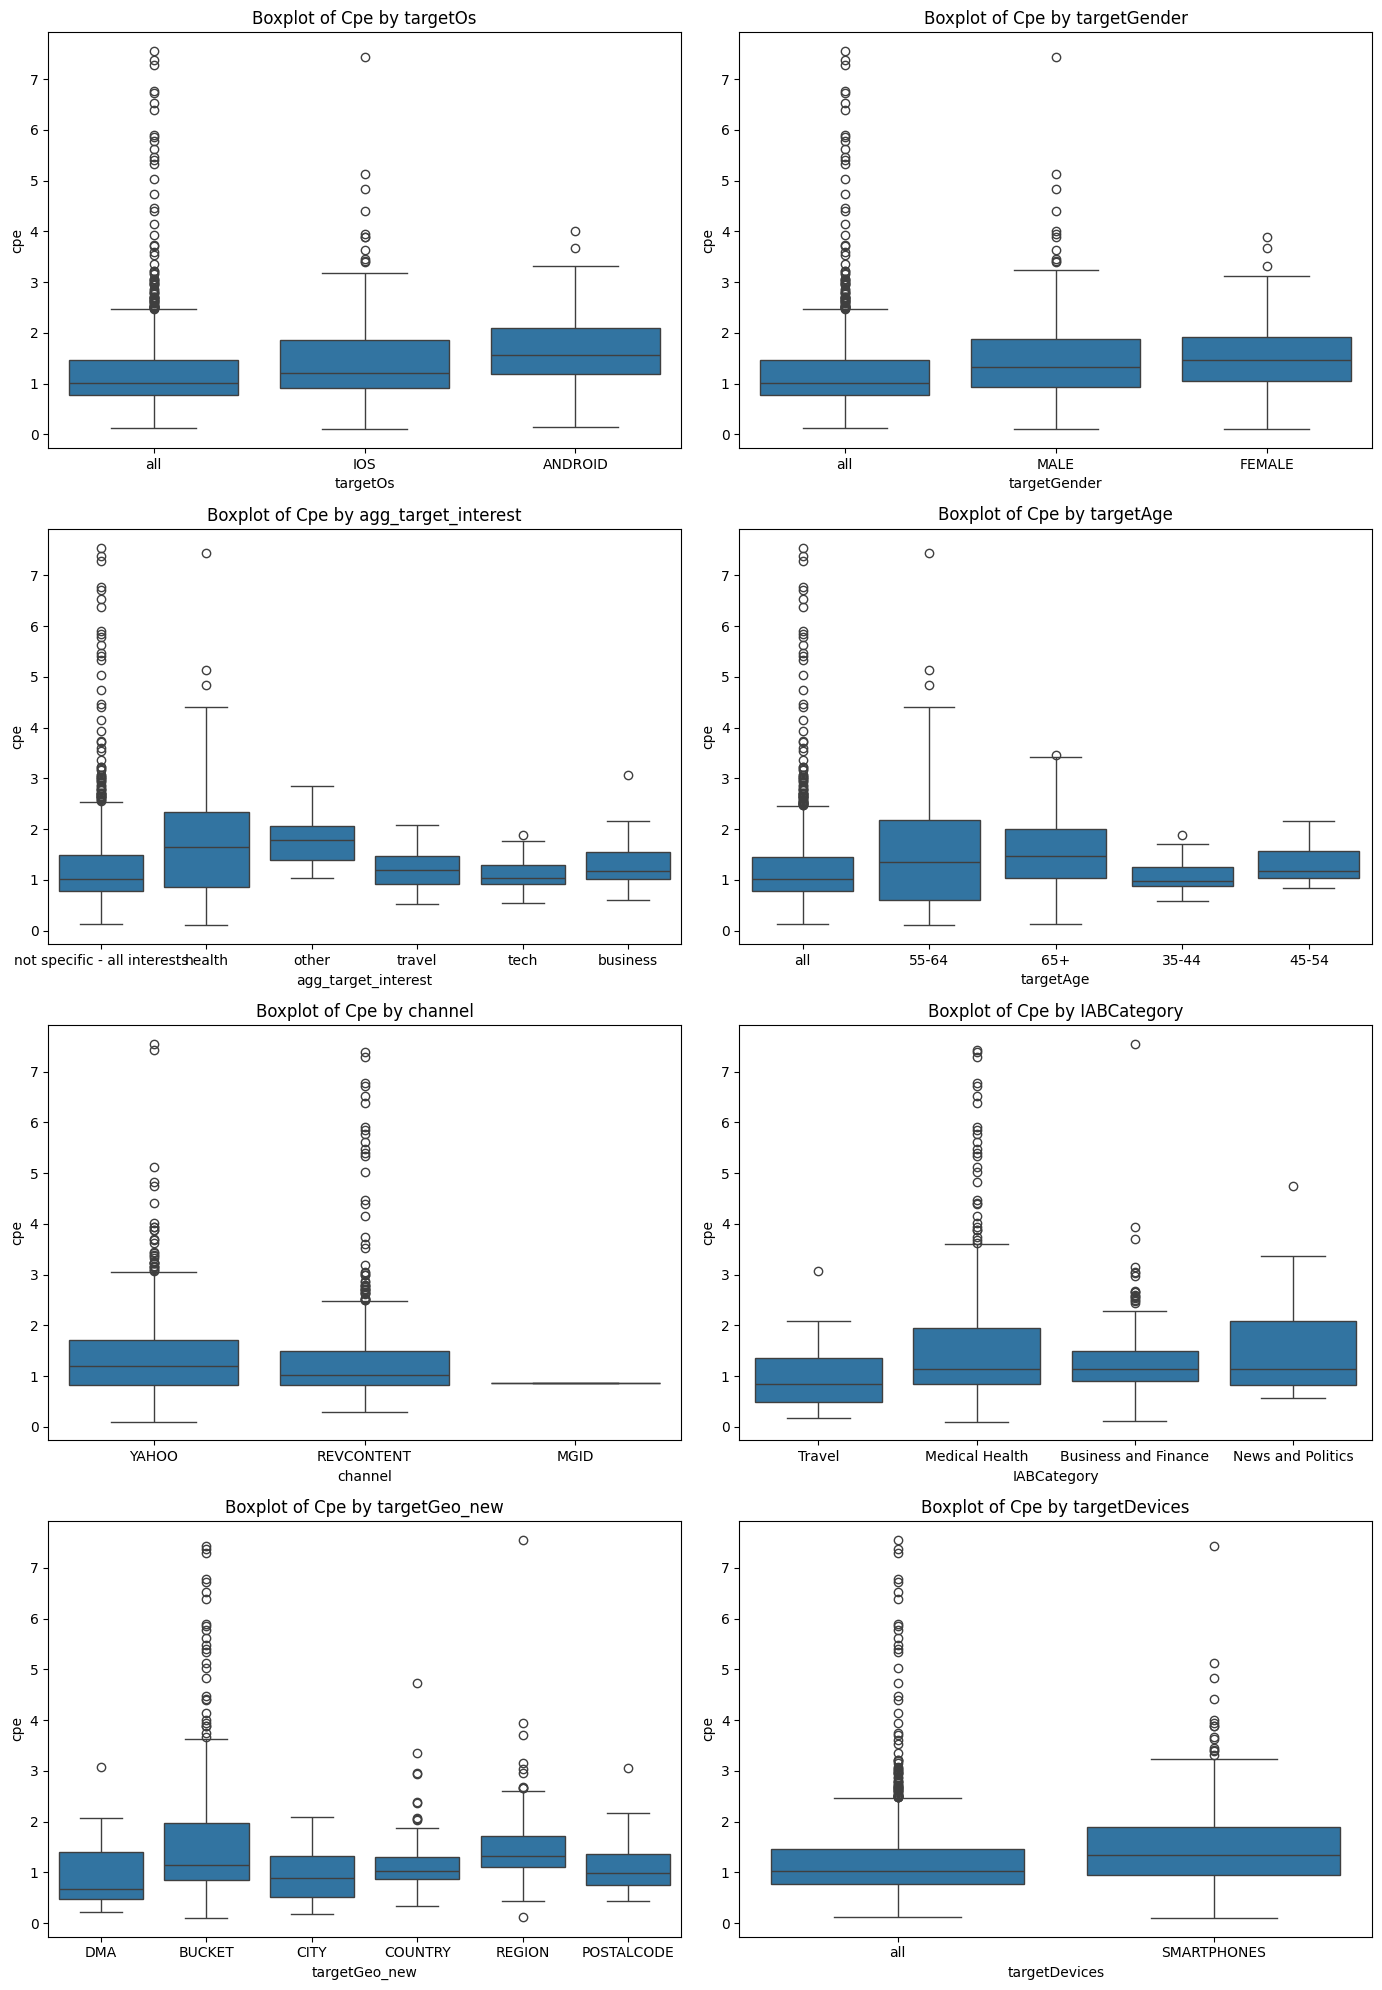

In [28]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 20))

axes = axes.flatten()

box_columns = [
    "targetOs", 
    "targetGender",
    "agg_target_interest", 
    "targetAge", 
    "channel", 
    "IABCategory", 
    "targetGeo_new",
    "targetDevices"
]

for i, box_column in enumerate(box_columns):
        sns.boxplot(x=box_column, y='cpe', data=processed_df, ax=axes[i])
        axes[i].set_title(f'Boxplot of Cpe by {box_column}')
        axes[i].set_xlabel(box_column)
        axes[i].set_ylabel('cpe')

plt.tight_layout()
plt.show()

- The category Medical Health of ad item type has the highest CPEs, compared to other categories
- The TargetGeo has more CPE outliers at broad levels (COUNTRY, BUCKET, REGION) and less where the target is more specific.

#### Linear correlation of numerical values

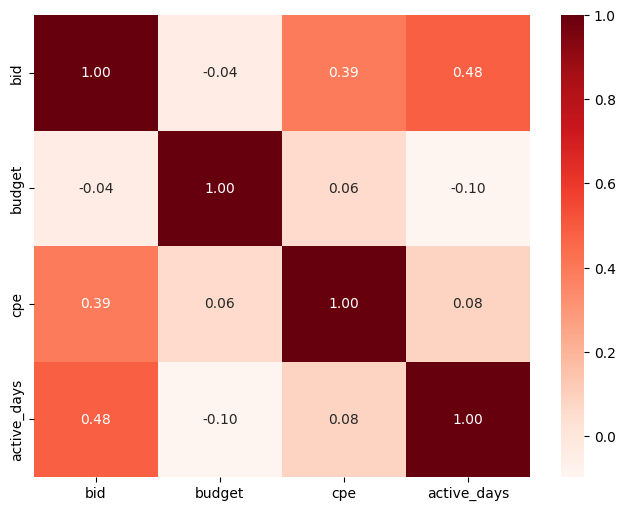

In [29]:
#correl bid, budget, cpe
correl_columns = [
    "bid", 
    "budget", 
    "cpe", 
    "active_days"
]

correl_matrix = processed_df[correl_columns].corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(correl_matrix, annot=True, cmap='Reds', fmt=".2f", annot_kws={"size": 10})
plt.show()

### Variable Encoding

Categorical variables will be encoded using One Hot Encoding / Dummy variables, since the number of categories is not so high and the distribution is balanced.

'targetAge', 'targetOs', 'targetDevices', 'targetGender', 'targetLanguages', 'agg_target_interest' > dummies

'targetGeo_new' > nominal according to coverage area / geo level: BUCKET> COUNTRY> REGION> DMA> CITY> POSTALCODE

In [30]:
encoded_df = processed_df.copy()

In [31]:
columns_to_encode = ['targetAge', 'targetOs', 'targetDevices', 'targetGender', 'targetLanguages', 'agg_target_interest']

In [32]:
encoded_df = pd.get_dummies(encoded_df, columns=columns_to_encode, drop_first=True)
encoded_df.head()

,group,item,channel,date,bid,budget,engagements,page_views,clicks,active_days,...,targetOs_all,targetDevices_all,targetGender_MALE,targetGender_all,targetLanguages_en,agg_target_interest_health,agg_target_interest_not specific - all interests,agg_target_interest_other,agg_target_interest_tech,agg_target_interest_travel
0,37,997,YAHOO,2021-12-21,0.263696,660.923913,138,388,411,4,...,True,True,False,True,False,False,True,False,False,False
1,37,1372,YAHOO,2021-12-21,0.263043,235.217391,80,253,270,4,...,True,True,False,True,False,False,True,False,False,False
2,37,1372,YAHOO,2021-12-22,0.366809,1060.638298,251,856,905,5,...,True,True,False,True,False,False,True,False,False,False
3,37,997,YAHOO,2021-12-22,0.367447,2317.021277,219,687,723,5,...,True,True,False,True,False,False,True,False,False,False
4,37,997,YAHOO,2021-12-23,0.419130,2600.000000,201,682,722,6,...,True,True,False,True,False,False,True,False,False,False


In [33]:
print(processed_df.shape)
print(encoded_df.shape)

(1682, 30)
(1682, 39)


9 new columns were created from the category dummies.

In [34]:
encoded_df.columns

Index(['group', 'item', 'channel', 'date', 'bid', 'budget', 'engagements',
       'page_views', 'clicks', 'active_days', 'media_spend', 'media_cpc',
       'cpe', 'headline', 'storySummary', 'IABCategory', 'targetGeo',
       'targetInterest', 'CATEGORY_1', 'all_geotypes', 'targetGeo_new',
       'geotype_2', 'all_interestids', 'interest_1', 'targetAge_45-54',
       'targetAge_55-64', 'targetAge_65+', 'targetAge_all', 'targetOs_IOS',
       'targetOs_all', 'targetDevices_all', 'targetGender_MALE',
       'targetGender_all', 'targetLanguages_en', 'agg_target_interest_health',
       'agg_target_interest_not specific - all interests',
       'agg_target_interest_other', 'agg_target_interest_tech',
       'agg_target_interest_travel'],
      dtype='object')

In [35]:
geo_level_mapping = {
    'BUCKET': 6,
    'COUNTRY': 5,
    'REGION': 4,
    'DMA': 3,
    'CITY': 2,
    'POSTALCODE': 1
}

encoded_df['targetGeo_encoded'] = encoded_df['targetGeo_new'].map(geo_level_mapping)

### Text preprocessing

To use the Creative information in the ML model to predict CPE, the text has to be processed: converted to lowercase, without punctuation, tokenized, be free of stopwords that do not add much meaning, and lemmatized (root word). 

Spacy English small model trained with Web data will be used (en_core_web_sm).

In [36]:
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text, stopwords=None):
    # convert to lowercase, remove punctuations and characters and then strip
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

    # tokenize (convert from string to list)
    lst_text = text.split()

    # remove Stopwords
    if stopwords:
        lst_text = [word for word in lst_text if word not in stopwords]

    # initialize spacy tokenizer
    doc = nlp(" ".join(lst_text))

    ## Lemmatization (convert the word into root word)
    lst_text = [token.lemma_ for token in doc]

    ## back to string from list
    text = " ".join(lst_text)
    return text

In [37]:
stop_words_list = stop_words.STOP_WORDS

In [38]:
encoded_df["headline_clean"] = encoded_df["headline"].apply(
    lambda x: preprocess_text(x, stopwords=stop_words_list)
)

In [39]:
encoded_df["summary_clean"] = encoded_df["storySummary"].apply(
    lambda x: preprocess_text(x, stopwords=stop_words_list)
)

In [40]:
encoded_df[['headline', 'headline_clean', 'storySummary', 'summary_clean']].head()

,headline,headline_clean,storySummary,summary_clean
0,Get Valuable Discounts with AAA. Join for 50% Off,valuable discount aaa join 50,Peace of Mind with AAA Roadside Service. Join ...,peace mind aaa roadside service join today lim...
1,Peace of Mind with AAA Roadside Service. Join Now,peace mind aaa roadside service join,Peace of Mind with AAA Roadside Service. Join ...,peace mind aaa roadside service join today lim...
2,Peace of Mind with AAA Roadside Service. Join Now,peace mind aaa roadside service join,Peace of Mind with AAA Roadside Service. Join ...,peace mind aaa roadside service join today lim...
3,Get Valuable Discounts with AAA. Join for 50% Off,valuable discount aaa join 50,Peace of Mind with AAA Roadside Service. Join ...,peace mind aaa roadside service join today lim...
4,Get Valuable Discounts with AAA. Join for 50% Off,valuable discount aaa join 50,Peace of Mind with AAA Roadside Service. Join ...,peace mind aaa roadside service join today lim...


The headline text does not seem to differ significantly from summary. Only the headline feature will be tested initially, to avoid high dimensionality of the dataset when vectorizing the text.

In [41]:
encoded_df.columns

Index(['group', 'item', 'channel', 'date', 'bid', 'budget', 'engagements',
       'page_views', 'clicks', 'active_days', 'media_spend', 'media_cpc',
       'cpe', 'headline', 'storySummary', 'IABCategory', 'targetGeo',
       'targetInterest', 'CATEGORY_1', 'all_geotypes', 'targetGeo_new',
       'geotype_2', 'all_interestids', 'interest_1', 'targetAge_45-54',
       'targetAge_55-64', 'targetAge_65+', 'targetAge_all', 'targetOs_IOS',
       'targetOs_all', 'targetDevices_all', 'targetGender_MALE',
       'targetGender_all', 'targetLanguages_en', 'agg_target_interest_health',
       'agg_target_interest_not specific - all interests',
       'agg_target_interest_other', 'agg_target_interest_tech',
       'agg_target_interest_travel', 'targetGeo_encoded', 'headline_clean',
       'summary_clean'],
      dtype='object')

#### Select columns to predict CPE: bid, budget, creative headline, targets

In [42]:
final_df = encoded_df[[
    'bid', 'budget', 'cpe','targetAge_45-54',
    'targetAge_55-64', 'targetAge_65+', 'targetAge_all', 'targetOs_IOS',
    'targetOs_all', 'targetDevices_all', 'targetGender_MALE',
    'targetGender_all', 'targetLanguages_en', 'agg_target_interest_health',
    'agg_target_interest_not specific - all interests',
    'agg_target_interest_other', 'agg_target_interest_tech',
    'agg_target_interest_travel', 'targetGeo_encoded', 'headline_clean'
]]

### Train, validation and test split

In [43]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

X_train_val, X_test = train_test_split(final_df, test_size=test_ratio, random_state=42)

X_train, X_val = train_test_split(X_train_val, test_size=val_ratio/(train_ratio+val_ratio), random_state=42)

### Preprocess steps: building a pipeline for data leakage sensitive steps

The vectorization process uses the frequency of words in the full data column. The transformation has to be executed separately in train, val and test to avoid data leakage.

#### Word vectorization: TF-idf + Univariate feature selection (to reduce dimensionality) using SelectKBest

In [44]:
def vectorizer_fit(max_features, corpus):
    vectorizer = feature_extraction.text.TfidfVectorizer(max_features = max_features, ngram_range=(1,2))
    tfidf_features = vectorizer.fit_transform(corpus)
    return vectorizer, tfidf_features

def vectorizer_transform(vectorizer, corpus):
    return vectorizer.transform(corpus)

def tfidf_to_columns(tfidf_features, vectorizer, suffix):
    tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=vectorizer.get_feature_names_out())
    suffix = f"_{suffix}"
    tfidf_df.columns = [col + suffix for col in tfidf_df.columns]
    return tfidf_df

def feature_selector_fit(k, X, y):
    feature_selector = SelectKBest(score_func=mutual_info_regression, k=k)
    X_selected = feature_selector.fit_transform(X, y)
    return feature_selector, X_selected

def feature_selector_transform(feature_selector, X):
    X_selected = feature_selector.transform(X)
    return X_selected

def feature_selector_to_columns(feature_selector, X, X_selected):
    selected_indices = feature_selector.get_support(indices=True)
    selected_feature_names = [X.columns[i] for i in selected_indices]
    X_selected_df = pd.DataFrame(X_selected, columns=selected_feature_names)
    return X_selected_df

def concat_selected_to_X(X_selected_df, X_df):
    X_selected_df.reset_index(drop=True, inplace=True)
    X_df.reset_index(drop=True, inplace=True)
    X_text_df = pd.concat([X_df, X_selected_df], axis=1)
    return X_text_df

def preprocess_train(X_train, max_features_tfidf, corpus_column, suffix, k_features_selector, target_column):
    """
    Uses a corpus to fit a TfidfVectorizer with ngrams=2. 
    Creates a df with each bigram as a column and the frequency as the value, and retrives the names of the columns, adding a suffix from the source of the text.
    Selects only the k features which are more related to the target using SelectKBest and function mutual info for regression.
    Transforms the selected features from array to dataframe, retrieving column name.
    Concatenates with the original dataset.

    Parameters:
    - X_train (Dataframe): train dataset
    - max_features_tfidf (int): Max features to be generated by the Tfidf vectorization.
    - corpus_column (list of strings or str): The corpus where the vectorizer will be trained. Here it is column of the dataset.
    - suffix: suffix to be added to the word-related features, indicating the source of the text (which column).
    - k_features_selector: number of best features to select
    - target_column (series of df): used to perform feature selection

    Returns:
    - concatenated dataframe
    - vectorizer to be used to transform the other sets
    - feature selector to be used to transform the other sets
    """
    vectorizer, tfidf_features = vectorizer_fit(max_features_tfidf, corpus_column)
    tf_idf_df = tfidf_to_columns(tfidf_features, vectorizer, suffix)
    feature_selector, X_selected = feature_selector_fit(k_features_selector, tf_idf_df, target_column)
    X_train_selected_df = feature_selector_to_columns(feature_selector, tf_idf_df,X_selected)
    return concat_selected_to_X(X_train_selected_df, X_train), vectorizer, feature_selector

def preprocess_val_test(X_data, vectorizer, feature_selector, corpus_column, suffix):
    """
    Consists of the same steps as preprocess_train(), except that applied to val and test sets.
    """
    tfidf_features = vectorizer_transform(vectorizer, corpus_column)
    tf_idf_df = tfidf_to_columns(tfidf_features, vectorizer, suffix)
    X_selected = feature_selector_transform(feature_selector, tf_idf_df)
    X_data_selected_df = feature_selector_to_columns(feature_selector, tf_idf_df, X_selected)
    return concat_selected_to_X(X_data_selected_df, X_data)

In [45]:
X_train_processed, vectorizer, feature_selector = preprocess_train(X_train, 1000, X_train["headline_clean"], 'headline', 30, X_train['cpe'])

X_val_processed = preprocess_val_test(X_val, vectorizer, feature_selector, X_val["headline_clean"], 'headline')

X_test_processed = preprocess_val_test(X_test, vectorizer, feature_selector, X_test["headline_clean"], 'headline')

print(X_train_processed.shape)
print(X_val_processed.shape)
print(X_test_processed.shape)

(1176, 50)
(253, 50)
(253, 50)


The train and validation datasets will be used to tune hyperparameters in the GridSearchCV. For that to function like a cross validation, we need to inform GridSearch we did a previous split of train / val. The 'split_index' variable is created for this purpose. 
(Reference: https://scikit-learn.org/stable/modules/cross_validation.html#predefined-fold-splits-validation-sets)

In [46]:
X_train_processed['split_index'] = -1
X_val_processed['split_index'] = 0

X_train_val_processed = pd.concat([X_train_processed, X_val_processed], ignore_index=True)

split_index = X_train_val_processed['split_index']

In [47]:
y_train_val = X_train_val_processed['cpe']

X_train_val_processed.drop(columns=['cpe','headline_clean','split_index'], inplace=True)

y_test = X_test_processed['cpe']

X_test_processed.drop(columns=['cpe','headline_clean'], inplace=True)

### Model, Hyperparameter tuning and Evaluation

In [106]:
# XGBoost Regression

xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'n_estimators': [50, 100, 150]
}

xgb_model = xgb.XGBRegressor(random_state=42)

pds = PredefinedSplit(test_fold=split_index)

grid_xgb = GridSearchCV(
    estimator=xgb_model,
    cv=pds,
    param_grid=xgb_param_grid,
    scoring='neg_mean_squared_error'
)

grid_xgb.fit(X_train_val_processed, y_train_val)

print("Best parameters:", grid_xgb.best_params_)
print("Best score in training (negated MSE):", grid_xgb.best_score_)

# Evaluate on test set
y_test_pred_xgb = grid_xgb.predict(X_test_processed)
mse_test_xgb = mean_squared_error(y_test, y_test_pred_xgb)
mae_test_xgb = mean_absolute_error(y_test, y_test_pred_xgb)

print("Test MSE:", mse_test_xgb)
print("Test MAE:", mae_test_xgb)

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 0.5}
Best score in training (negated MSE): -0.7201272903939352
Test MSE: 0.48778458956589066
Test MAE: 0.4121808111939336


In [109]:
# Random Forest Regression
rf_param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt', 1.0]
}


rf_model = RandomForestRegressor(random_state=42)

pds = PredefinedSplit(test_fold=split_index)

grid_rf = GridSearchCV(
    estimator=rf_model,
    cv=pds,
    param_grid=rf_param_grid,
    scoring='neg_mean_squared_error'
)

grid_rf.fit(X_train_val_processed, y_train_val)

print("Best parameters:", grid_rf.best_params_)
print("Best score in training (negated MSE):", grid_rf.best_score_)

# Evaluate on test set
y_test_pred_rf = grid_rf.predict(X_test_processed)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)

print("Test MSE:", mse_test_rf)
print("Test MAE:", mae_test_rf)

Best parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best score in training (negated MSE): -0.7098034025830896
Test MSE: 0.524418855007875
Test MAE: 0.42384398230660925


The XGBoost regressor has the best performance in MAE and MSE in the test set. This is the selected model.

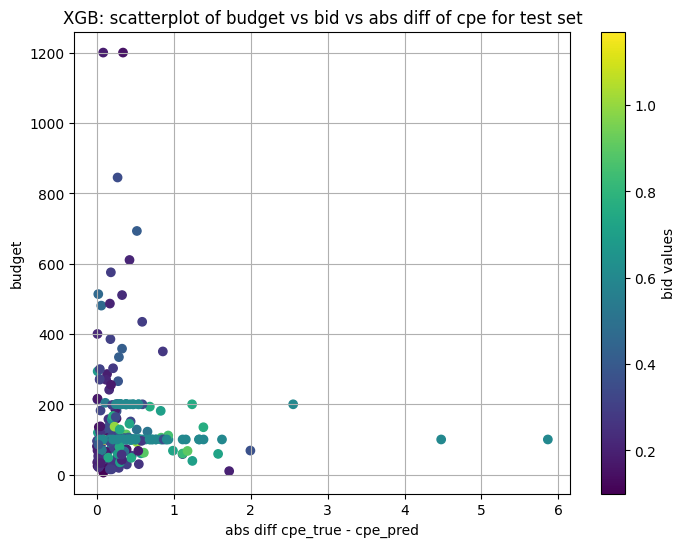

In [112]:
plt.figure(figsize=(8, 6))
plt.scatter(abs(y_test - y_test_pred_xgb), X_test_processed['budget'], c=X_test_processed['bid'], cmap='viridis')
plt.colorbar(label='bid values')
plt.title('XGB: scatterplot of budget vs bid vs abs diff of cpe for test set')
plt.xlabel('abs diff cpe_true - cpe_pred')
plt.ylabel('budget')
plt.grid(True)
plt.show()

### Explainability

Understanding the features that contributed the most to the model output with SHAP, a local model agnostic method of explanation.

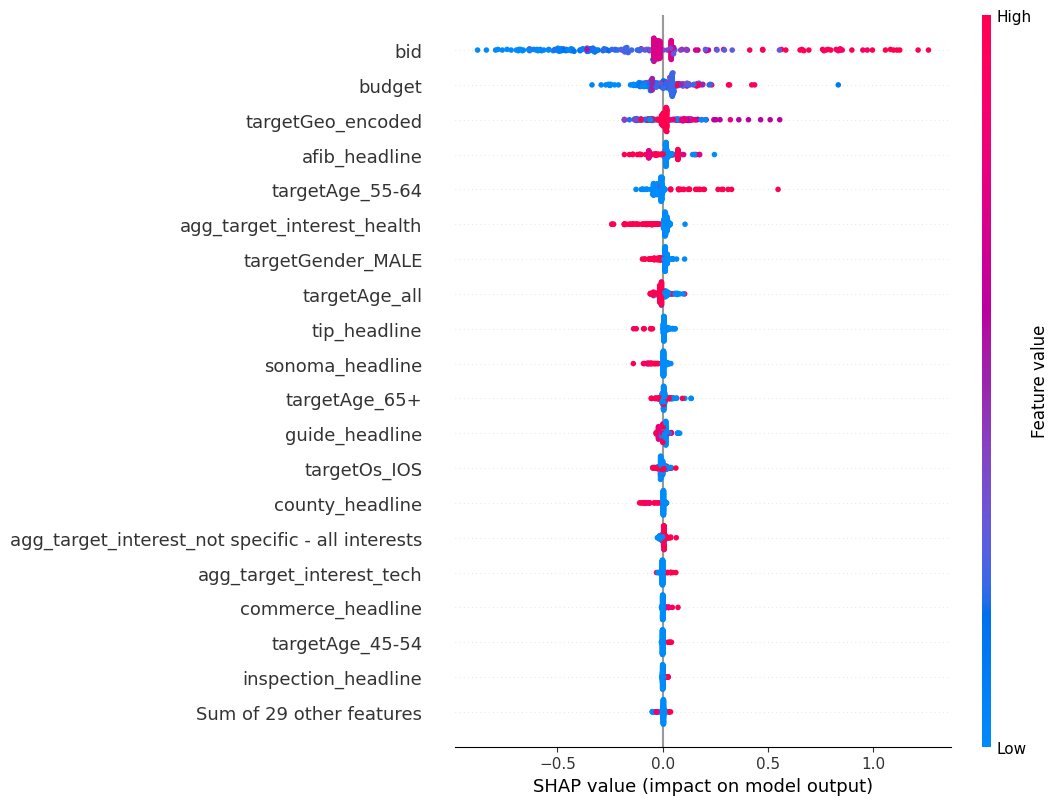

In [50]:
xgb_model = grid_xgb.best_estimator_

explainer = shap.TreeExplainer(xgb_model)
explanation = explainer(X_test_processed)

shap.plots.beeswarm(explanation, max_display=20)

#### Explaining the predictedted CPE of individual advertisement items

Explanaining the predictions for individual advertisement items can be extremely insighful both for advertisement managers but also to creative teams, sice the words are also features in the model. It makes the model output transparent and more actionable.

Below is the explanation for the predicted CPE for the first row of the test set. It has a predicted CPE of 1.008 (real CPE was 1.03). The estimative starts at the average 1.34, and changes according to features values: 
- bid (0.249) contributed to lower the predicted CPE by 0.39
- budget (62.295) contributed to lower CPE by 0.04
- TargetAge being True for 45-54 contributed to increase CPE by 0.04

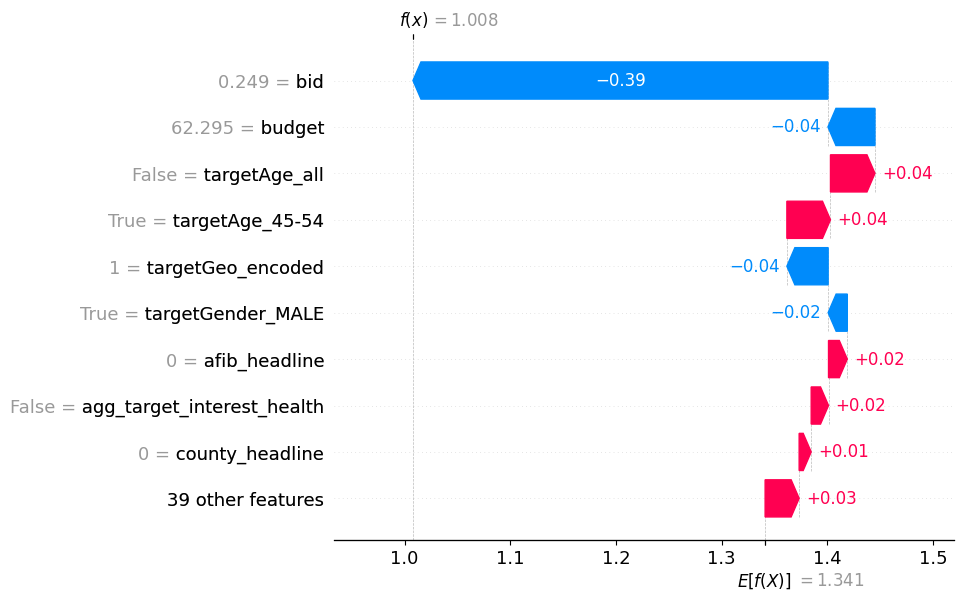

In [51]:
shap.plots.waterfall(explanation[0])

In [52]:
print(y_test.idxmax())

153


In [53]:
print(y_test[153])

7.380000305175781


##### Study case: Highest real CPE

Let's investigate the highest real CPE in the test set.
The highest real CPE value was 7.38. The predicted value was 1.516.
- having afib in the headline (0.375) contributed to raise the predicted CPE by 0.07
- budget (100) contributed to raise the CPE by 0.04
- bid (0.6) contributed to lower the predicted CPE by 0.04

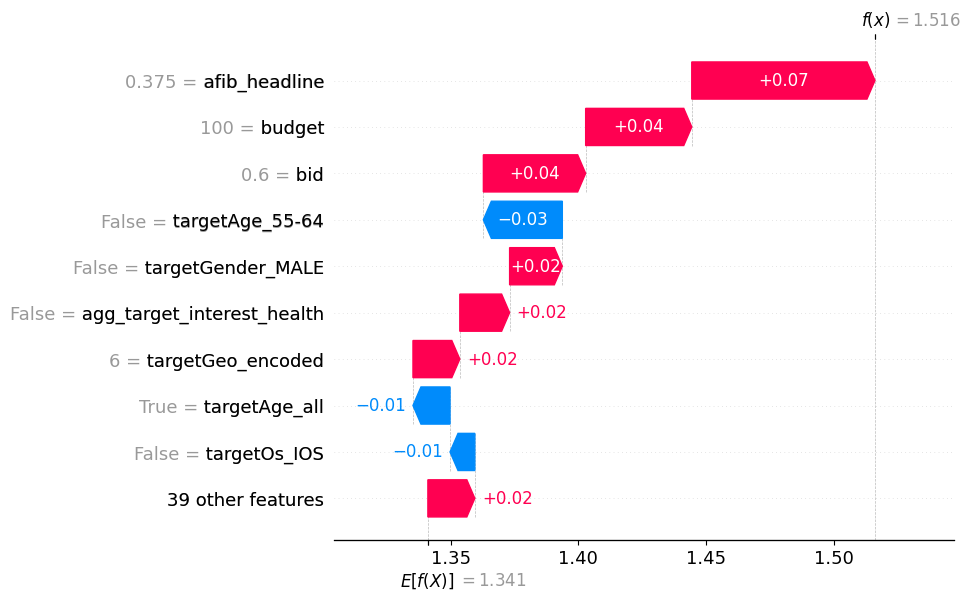

In [54]:
shap.plots.waterfall(explanation[153])

##### Study case: Smallest absolute error (CPE real vs CPE predicted)

Analysing the cases with smallest absolute error (real CPE vs predicted CPE) help understand which features are more consistent and reliable.

In [55]:
mae_xgb = abs(y_test_pred_xgb - y_test)

In [56]:
print(np.argmin(mae_xgb))

14


In [57]:
y_test[14]

0.3671428571428571

The prediction with the smallest error had a real CPE of 0.367 and a predicted CPE of 0.366.
- bid (0.17) contributed to lower the predicted CPE by 0.68
- 'county' and 'sonoma' in the headline contributed to lowering the CPE by 0.14
- the targetGeo level 2 (CITY) contributed to lowering the CPE by 0.11

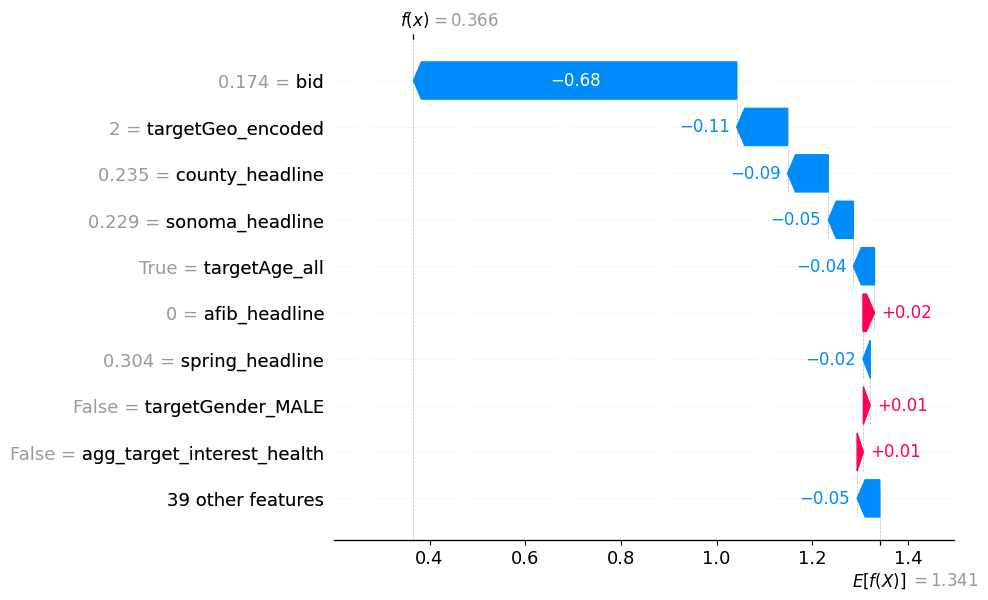

In [58]:
shap.plots.waterfall(explanation[14])

### Optimization

In [72]:
from skopt import gp_minimize
from skopt.space import Real

fixed_bid = 0.17

# Define the objective function
def objective_function(budget):
    X_pred = X_test_processed.iloc[[14]].copy()  
    X_pred.iloc[0, 0] = fixed_bid
    X_pred.iloc[0, 1] = budget
    
    xgb_model = grid_xgb.best_estimator_
    cpe_pred = xgb_model.predict(X_pred) # returns as array
    
    return cpe_pred[0]

# search space for bid
space = [Real(10, 100, name='budget')]

# Bayesian optimization
result = gp_minimize(objective_function, space, n_calls=100, random_state=42)

# Extract the best bid value found by Bayesian optimization
best_budget = result.x
best_cpe = result.fun  

print("Best CPE:", best_cpe)
print("Best Budget:", best_budget)

Best CPE: 0.328022
Best Budget: [40.03377500251197]


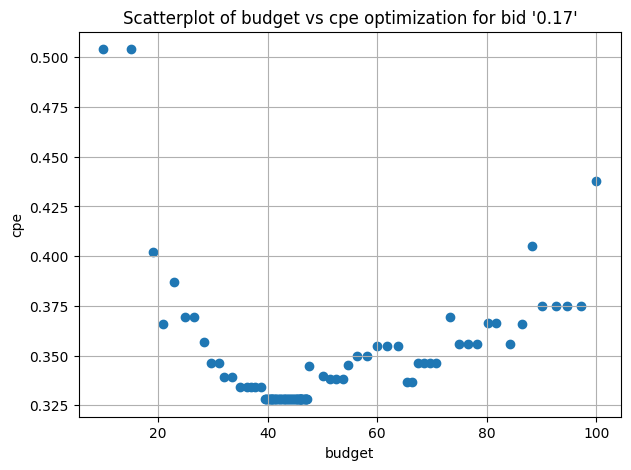

In [73]:
plt.figure(figsize=(7, 5))
plt.scatter([x[0] for x in result.x_iters], result.func_vals) # x_iters is a list of lists
plt.title(f"Scatterplot of budget vs cpe optimization for bid '{fixed_bid}'")
plt.xlabel('budget')
plt.ylabel('cpe')
plt.grid(True)
plt.show()